In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# check content of drive
!ls "/content/drive/My Drive/THESIS 2/Thesis Internal/Code"

model


In [3]:
# gspread automated results
import gspread
from google.colab import auth
from google.auth import default
from gspread.utils import rowcol_to_a1

# Authenticate the user
auth.authenticate_user()

# Create a gspread client using the authenticated Google credentials
creds, _ = default()
gc = gspread.authorize(creds)

# Open a spreadsheet by its title or URL
spreadsheet = gc.open('inceptionv3_testcases')  # Replace with your spreadsheet name
sheet = spreadsheet.sheet1  # Access the first sheet

In [4]:
%matplotlib inline
from IPython import display
import os
import math
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import *
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

np.random.seed(42)
tf.random.set_seed(42)

## Importing and Splitting the dataset

In [5]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

data_dir = "/content/drive/My Drive/Thesis Internal/Code/dataset/train_split_mfcc_Depression_AVEC2017_2" #change_path
test_data_dir = "/content/drive/My Drive/Thesis Internal/Code/dataset/test_split_mfcc_Depression_AVEC2017_2" #change_path

aug_data_dir = "/content/drive/My Drive/Thesis Internal/Code/dataset/dev_split_mfcc_augmented_Depression_AVEC2017_2" #change_path

def image_generator(height, width):
    datagen = ImageDataGenerator(
        rescale=1./255.,
        validation_split=0.1, #to change split
    )

    test_datagen = ImageDataGenerator(
        rescale=1./255.
    )

    aug_datagen = ImageDataGenerator(
        rescale=1./255.
    )

    # Modify the flow_from_directory method to handle 5 classes
    train_ds = datagen.flow_from_directory(
        data_dir,
        batch_size=batch_size,
        subset="training",
        shuffle=True,
        class_mode='categorical', #changed
        target_size=(height, width),
        classes={'level_0': 0, 'level_1': 1, 'level_2': 2, 'level_3': 3, 'level_4': 4}
    )

    val_ds = datagen.flow_from_directory(
        data_dir,
        subset="validation",
        class_mode='categorical', #changed
        target_size=(height, width),
        batch_size=batch_size,
        classes={'level_0': 0, 'level_1': 1, 'level_2': 2, 'level_3': 3, 'level_4': 4}
    )

    test_ds = test_datagen.flow_from_directory(
        test_data_dir,
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical', #changed
        target_size=(height, width),
        classes={'level_0': 0, 'level_1': 1, 'level_2': 2, 'level_3': 3, 'level_4': 4}
    )

    aug_train_ds = aug_datagen.flow_from_directory(
        aug_data_dir,
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical', #changed
        target_size=(height, width),
        classes={'level_0': 0, 'level_1': 1, 'level_2': 2, 'level_3': 3, 'level_4': 4}
    )

    return train_ds, val_ds, test_ds, aug_train_ds

batch_size = 32  # add batch_size here or elsewhere in your code
height, width = 400, 1000  #change

def print_class_counts(ds, dataset_name):
    class_counts = {}
    for i in range(5):
        class_name = f'level_{i}'
        class_counts[class_name] = len(np.where(ds.labels == i)[0])
    print(f'\nClass counts for {dataset_name}:')
    print(class_counts)

# After initializing your datasets
train_ds, val_ds, test_ds, aug_train_ds = image_generator(height, width)

# Now print class counts for each dataset
print_class_counts(train_ds, "Training Dataset")
print_class_counts(val_ds, "Validation Dataset")
print_class_counts(test_ds, "Test Dataset")
print_class_counts(aug_train_ds, "Augmented Training Dataset")

Found 130 images belonging to 5 classes.
Found 12 images belonging to 5 classes.
Found 47 images belonging to 5 classes.
Found 567 images belonging to 5 classes.

Class counts for Training Dataset:
{'level_0': 58, 'level_1': 32, 'level_2': 23, 'level_3': 12, 'level_4': 5}

Class counts for Validation Dataset:
{'level_0': 6, 'level_1': 3, 'level_2': 2, 'level_3': 1, 'level_4': 0}

Class counts for Test Dataset:
{'level_0': 22, 'level_1': 11, 'level_2': 5, 'level_3': 7, 'level_4': 2}

Class counts for Augmented Training Dataset:
{'level_0': 258, 'level_1': 138, 'level_2': 90, 'level_3': 60, 'level_4': 21}


## Visualizing the dataset

In [6]:
# import matplotlib.pyplot as plt

# # single_image_height = 4  # inches
# # single_image_width = single_image_height * 2.5  # inches

# # fig_width = 2 * single_image_width  # since there are 2 columns
# # fig_height = 5 * single_image_height  # since there are 5 rows

# # fig, ax = plt.subplots(5, 2, figsize=(fig_width, fig_height))
# fig, ax = plt.subplots(5, 2, figsize=(10, 10))  # 5 levels x 2 samples
# fig.suptitle("mfcc_depression_levels_samples")

# class_dict = {v: k for k, v in train_ds.class_indices.items()}
# samples_needed = {k: 2 for k in range(5)}
# collected_samples = {k: [] for k in range(5)}

# while any(v > 0 for v in samples_needed.values()):
#     images, labels = train_ds.next()
#     for image, label in zip(images, labels):
#         label_index = np.argmax(label)
#         if samples_needed[label_index] > 0:
#             collected_samples[label_index].append(image)
#             samples_needed[label_index] -= 1

# # Plot the collected samples
# for label_index, images_list in collected_samples.items():
#     for i, image in enumerate(images_list):
#         ax[label_index, i].imshow(image)
#         ax[label_index, i].set_title(f'{class_dict[label_index]}')
#         ax[label_index, i].axis('off')

# plt.tight_layout()
# plt.subplots_adjust(top=0.95)  # Adjust the top space for the main title
# plt.show()


## Visualizing the augmented dataset

In [7]:
# import matplotlib.pyplot as plt

# # single_image_height = 4  # inches
# # single_image_width = single_image_height * 2.5  # inches

# # fig_width = 2 * single_image_width  # since there are 2 columns
# # fig_height = 5 * single_image_height  # since there are 5 rows

# # fig, ax = plt.subplots(5, 2, figsize=(fig_width, fig_height))
# fig, ax = plt.subplots(5, 2, figsize=(10, 10))  # 5 levels x 2 samples
# fig.suptitle("mfcc_depression_levels_samples")

# class_dict = {v: k for k, v in aug_train_ds.class_indices.items()}
# samples_needed = {k: 2 for k in range(5)}
# collected_samples = {k: [] for k in range(5)}

# while any(v > 0 for v in samples_needed.values()):
#     images, labels = aug_train_ds.next()
#     for image, label in zip(images, labels):
#         label_index = np.argmax(label)
#         if samples_needed[label_index] > 0:
#             collected_samples[label_index].append(image)
#             samples_needed[label_index] -= 1

# # Plot the collected samples
# for label_index, images_list in collected_samples.items():
#     for i, image in enumerate(images_list):
#         ax[label_index, i].imshow(image)
#         ax[label_index, i].set_title(f'{class_dict[label_index]}')
#         ax[label_index, i].axis('off')

# plt.tight_layout()
# plt.subplots_adjust(top=0.95)  # Adjust the top space for the main title
# plt.show()


# Applying Class Weights to address Imbalanced dataset

In [8]:
#adding class weights
from sklearn.utils.class_weight import compute_class_weight

# Assuming train_ds.classes provides the class indices of the training data
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_ds.classes),
    y=train_ds.classes
)

# Turn class_weights into a dictionary to use it with Keras
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}


## To keep track of Time duration during training

In [9]:
import time

class TimingCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(TimingCallback, self).__init__()
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        elapsed_time = time.time() - self.start_time
        self.epoch_times.append(elapsed_time)
        print(f"Epoch {epoch + 1}: {elapsed_time:.2f} seconds")

    def on_train_begin(self, logs=None):
        self.total_time = time.time()

    def on_train_end(self, logs=None):
        total_time_elapsed = time.time() - self.total_time
        avg_time_per_epoch = sum(self.epoch_times) / len(self.epoch_times)
        print(f"Total training time: {total_time_elapsed:.2f} seconds")
        print(f"Average time per epoch: {avg_time_per_epoch:.2f} seconds")


## Initial InceptionV3 + BiLSTM Model


In [10]:
# import tensorflow as tf
# from tensorflow.keras import layers

# input_shape = (height, width, 3)  # Replace 'height' and 'width' with actual values

# # InceptionV3 base model
# base_model_inceptionv3 = tf.keras.applications.InceptionV3(
#     weights='imagenet',
#     include_top=False,
#     input_shape=input_shape
# )
# base_model_inceptionv3.trainable = False

# # Sequential model
# model_inceptionv3 = tf.keras.Sequential([
#     base_model_inceptionv3,
#     layers.Flatten(),
#     layers.Reshape((1, -1)),  # Reshape for BiLSTM
#     layers.Bidirectional(layers.LSTM(16)),  # BiLSTM layer
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.25),
#     layers.Dense(5, activation='softmax')  # Assuming 5 classes
# ])

# model_inceptionv3.compile(
#     loss='categorical_crossentropy',
#     optimizer=tf.keras.optimizers.Adam(0.0001),
#     metrics=['accuracy']
# )

# model_inceptionv3.summary()


In [11]:
# # Adjusting to monitor validation accuracy
# checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/THESIS 2/Thesis Internal/Code/model/inceptionv3_initial_hybrid.h5', monitor='val_loss', verbose=1, mode='min', save_best_only=True)
# early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", restore_best_weights=True, patience=5)
# time_callback = TimingCallback()
# callbacks_list = [checkpoint, early, time_callback]
# # callbacks_list = [checkpoint]

# history = model_inceptionv3.fit(
#         train_ds,
#         validation_data=val_ds,
#         epochs=30,
#         shuffle=True,
#         verbose=True,
#         callbacks=callbacks_list,
#         class_weight=class_weight_dict  # Pass class weights here
# )

## Evaluation of *Initial Model*

In [12]:
# train_result = model_inceptionv3.evaluate(train_ds)
# val_result = model_inceptionv3.evaluate(val_ds)
# test_result = model_inceptionv3.evaluate(test_ds)

# no_augmented_df = pd.DataFrame(zip(train_result,val_result,test_result),columns=['Train','Val','Test'],index=['Loss','Acc'])
# no_augmented_df

In [13]:
# # plot learning curve
# def plot_learning_curve(history):
#     acc = history.history['accuracy']
#     val_acc = history.history['val_accuracy']
#     loss = history.history['loss']
#     val_loss = history.history['val_loss']
#     epochs = range(len(acc))

#     plt.plot(epochs, acc, label='training acc')
#     plt.plot(epochs, val_acc, label='validation acc')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy-%')
#     plt.legend()
#     plt.figure()

#     plt.plot(epochs, loss, label='training loss')
#     plt.plot(epochs, val_loss, label='validation loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()

# plot_learning_curve(history)

In [14]:
# from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
# import matplotlib.pyplot as plt

# # 1. Predict the classes and probabilities for the test dataset
# test_pred_prob = model_inceptionv3.predict(test_ds)
# test_pred = np.argmax(test_pred_prob, axis=1)
# test_true = test_ds.labels

# # Determine the number of classes in the test dataset
# n_classes = len(np.unique(test_true))

# # 2. Compute the metrics for the test dataset

# # Test metrics
# test_precision = precision_score(test_true, test_pred, average='weighted', zero_division=1)
# test_recall = recall_score(test_true, test_pred, average='weighted')
# test_f1 = f1_score(test_true, test_pred, average='weighted')
# test_conf_matrix = confusion_matrix(test_true, test_pred, labels=list(range(n_classes)))
# test_true_onehot = np.eye(n_classes)[test_true]
# test_roc_auc = roc_auc_score(test_true_onehot, test_pred_prob, multi_class='ovr')

# # Create a dataframe to display the results for the test set
# test_metrics_df = pd.DataFrame({
#     'Test': [test_precision, test_recall, test_f1, test_roc_auc]
# }, index=['Precision', 'Recall', 'F1 Score', 'AUC'])

# print("Test Metrics DataFrame:")
# print(test_metrics_df)

# print("\nTest Confusion Matrix:")
# print(test_conf_matrix)


In [15]:
# # Assuming test_conf_matrix is already computed as shown in your code
# n_classes = len(np.unique(test_true))  # Number of classes

# # Initialize arrays to store TP, FP, FN, TN for each class
# TP = np.zeros(n_classes)
# FP = np.zeros(n_classes)
# FN = np.zeros(n_classes)
# TN = np.zeros(n_classes)

# # Calculate TP, FP, FN, TN for each class
# for i in range(n_classes):
#     TP[i] = test_conf_matrix[i, i]
#     FP[i] = test_conf_matrix[:, i].sum() - TP[i]
#     FN[i] = test_conf_matrix[i, :].sum() - TP[i]
#     TN[i] = test_conf_matrix.sum() - (FP[i] + FN[i] + TP[i])

# print("Confusion Matrix Metrics by Class:")
# TP_list = TP.tolist()
# TN_list = TN.tolist()
# FP_list = FP.tolist()
# FN_list = FN.tolist()

# metrics_by_class = list(zip(TP_list, TN_list, FP_list, FN_list))

# # Print the transposed lists
# for i, class_metrics in enumerate(metrics_by_class):
#     print(f"Class {i}: {class_metrics}")

In [16]:
# #Matrix Visualization
# # Training AUC curve
# plt.figure(figsize=(10, 8))
# for i in range(n_classes):
#     fpr, tpr, _ = roc_curve(test_true_onehot[:, i], test_pred_prob[:, i])
#     plt.plot(fpr, tpr, lw=2, label=f'Testing ROC curve of class {i} (area = {auc(fpr, tpr):.2f})')
# plt.plot([0, 1], [0, 1], 'k--', lw=2)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic for Testing Data')
# plt.legend(loc="lower right")
# plt.show()

**TEST CASES INSERTION**

In [17]:

# # Assuming that the TP_list, TN_list, FP_list, and FN_list have been calculated
# TP_list = TP.tolist()
# TN_list = TN.tolist()
# FP_list = FP.tolist()
# FN_list = FN.tolist()
# metrics_flat = [item for sublist in zip(TP_list, TN_list, FP_list, FN_list) for item in sublist]

# # Data to append
# data_to_append = [
#     #ACCCURACY AND LOSS
#     train_result[0],  # Training loss [B]
#     train_result[1],  # Training accuracy [C]
#     val_result[0],    # Validation loss [D]
#     val_result[1],     # Validation accuracy [E]
#     test_result[0],    # Testing loss [F]
#     test_result[1],     # Testing accuracy [G]
#     test_precision,
#     test_recall,
#     test_f1,
#     test_roc_auc
# ]

# #Insertion
# # Find the first empty row in column B
# col_values = sheet.col_values(2)  # Column number for 'B' is 2
# first_empty_row = len(col_values) + 1

# # Calculate the range to update
# start_cell = rowcol_to_a1(first_empty_row, 2)  # Start at column B
# end_cell = rowcol_to_a1(first_empty_row, 1 + len(data_to_append))  # Adjust the end column based on data length
# cell_range = f"{start_cell}:{end_cell}"

# # Update the entire row at once
# sheet.update(cell_range, [data_to_append])

# #FOR CONFUSION MATRIX INSERTION
# # Loop through the metrics_flat and update each cell
# for index, value in enumerate(metrics_flat):
#     # Calculate row and column offset
#     row_offset = (index // 4) + first_empty_row
#     col_offset = (index % 4) + 12

#     # Convert to A1 notation and update the cell
#     cell_range = rowcol_to_a1(first_empty_row, 12) + ':' + rowcol_to_a1(first_empty_row, 12 + len(metrics_flat) - 1)
#     sheet.update(cell_range, [metrics_flat])

In [18]:
# # Add a ReduceLROnPlateau callback to reduce the learning rate when the validation loss plateaus
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.2,
#     patience=5,
#     min_lr=0.00001, #to change reduce_lr
#     verbose=1
# )
# callbacks_list = [checkpoint, early, time_callback, reduce_lr]

# history = model_inceptionv3.fit(
#         aug_train_ds,
#         validation_data=val_ds,
#         epochs=30,
#         shuffle=True,
#         verbose=True,
#         callbacks=callbacks_list,
#         class_weight=class_weight_dict  # Pass class weights here
#         )


## Evaluation of *Initial Model* with **Augmentation**

In [19]:
# train_result = model_inceptionv3.evaluate(train_ds)
# val_result = model_inceptionv3.evaluate(val_ds)
# test_result = model_inceptionv3.evaluate(test_ds)

# augmented_df = pd.DataFrame(zip(train_result,val_result,test_result),columns=['Train','Val','Test'],index=['Loss','Acc'])
# augmented_df

In [20]:
# # plot learning curve
# def plot_learning_curve(history):
#     acc = history.history['accuracy']
#     val_acc = history.history['val_accuracy']
#     loss = history.history['loss']
#     val_loss = history.history['val_loss']
#     epochs = range(len(acc))

#     plt.plot(epochs, acc, label='training acc')
#     plt.plot(epochs, val_acc, label='validation acc')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy-%')
#     plt.legend()
#     plt.figure()

#     plt.plot(epochs, loss, label='training loss')
#     plt.plot(epochs, val_loss, label='validation loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()

# plot_learning_curve(history)

In [21]:
# #METRICS
# from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
# import matplotlib.pyplot as plt

# # 1. Predict the classes and probabilities for the test dataset
# test_pred_prob = model_inceptionv3.predict(test_ds)
# test_pred = np.argmax(test_pred_prob, axis=1)
# test_true = test_ds.labels

# # Determine the number of classes in the test dataset
# n_classes = len(np.unique(test_true))

# # 2. Compute the metrics for the test dataset

# # Test metrics
# test_precision = precision_score(test_true, test_pred, average='weighted', zero_division=1)
# test_recall = recall_score(test_true, test_pred, average='weighted')
# test_f1 = f1_score(test_true, test_pred, average='weighted')
# test_conf_matrix = confusion_matrix(test_true, test_pred, labels=list(range(n_classes)))
# test_true_onehot = np.eye(n_classes)[test_true]
# test_roc_auc = roc_auc_score(test_true_onehot, test_pred_prob, multi_class='ovr')

# # Create a dataframe to display the results for the test set
# test_metrics_df = pd.DataFrame({
#     'Test': [test_precision, test_recall, test_f1, test_roc_auc]
# }, index=['Precision', 'Recall', 'F1 Score', 'AUC'])

# print("Test Metrics DataFrame:")
# print(test_metrics_df)

# print("\nTest Confusion Matrix:")
# print(test_conf_matrix)


In [22]:
# # Assuming test_conf_matrix is already computed as shown in your code
# n_classes = len(np.unique(test_true))  # Number of classes

# # Initialize arrays to store TP, FP, FN, TN for each class
# TP = np.zeros(n_classes)
# FP = np.zeros(n_classes)
# FN = np.zeros(n_classes)
# TN = np.zeros(n_classes)

# # Calculate TP, FP, FN, TN for each class
# for i in range(n_classes):
#     TP[i] = test_conf_matrix[i, i]
#     FP[i] = test_conf_matrix[:, i].sum() - TP[i]
#     FN[i] = test_conf_matrix[i, :].sum() - TP[i]
#     TN[i] = test_conf_matrix.sum() - (FP[i] + FN[i] + TP[i])

# print("Confusion Matrix Metrics by Class:")
# TP_list = TP.tolist()
# TN_list = TN.tolist()
# FP_list = FP.tolist()
# FN_list = FN.tolist()

# metrics_by_class = list(zip(TP_list, TN_list, FP_list, FN_list))

# # Print the transposed lists
# for i, class_metrics in enumerate(metrics_by_class):
#     print(f"Class {i}: {class_metrics}")

In [23]:
# #Matrix Visualization
# # Testing AUC curve
# plt.figure(figsize=(10, 8))
# for i in range(n_classes):
#     fpr, tpr, _ = roc_curve(test_true_onehot[:, i], test_pred_prob[:, i])
#     plt.plot(fpr, tpr, lw=2, label=f'Testing ROC curve of class {i} (area = {auc(fpr, tpr):.2f})')
# plt.plot([0, 1], [0, 1], 'k--', lw=2)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic for Testing Data')
# plt.legend(loc="lower right")
# plt.show()

In [24]:
# #TEST CASES INSERTION

# # Assuming that the TP_list, TN_list, FP_list, and FN_list have been calculated
# TP_list = TP.tolist()
# TN_list = TN.tolist()
# FP_list = FP.tolist()
# FN_list = FN.tolist()
# metrics_flat = [item for sublist in zip(TP_list, TN_list, FP_list, FN_list) for item in sublist]

# # Data to append
# data_to_append = [
#     #ACCCURACY AND LOSS
#     train_result[0],  # Training loss [B]
#     train_result[1],  # Training accuracy [C]
#     val_result[0],    # Validation loss [D]
#     val_result[1],     # Validation accuracy [E]
#     test_result[0],    # Testing loss [F]
#     test_result[1],     # Testing accuracy [G]
#     test_precision,
#     test_recall,
#     test_f1,
#     test_roc_auc
# ]

# #Insertion
# # Find the first empty row in column B
# col_values = sheet.col_values(2)  # Column number for 'B' is 2
# first_empty_row = len(col_values) + 1

# # Calculate the range to update
# start_cell = rowcol_to_a1(first_empty_row, 2)  # Start at column B
# end_cell = rowcol_to_a1(first_empty_row, 1 + len(data_to_append))  # Adjust the end column based on data length
# cell_range = f"{start_cell}:{end_cell}"

# # Update the entire row at once
# sheet.update(cell_range, [data_to_append])

# #FOR CONFUSION MATRIX INSERTION
# # Loop through the metrics_flat and update each cell
# for index, value in enumerate(metrics_flat):
#     # Calculate row and column offset
#     row_offset = (index // 4) + first_empty_row
#     col_offset = (index % 4) + 12

#     # Convert to A1 notation and update the cell
#     cell_range = rowcol_to_a1(first_empty_row, 12) + ':' + rowcol_to_a1(first_empty_row, 12 + len(metrics_flat) - 1)
#     sheet.update(cell_range, [metrics_flat])

## Tuned InceptionV3 + BiLSTM Model

In [25]:
import tensorflow as tf
from keras.regularizers import l2

tf.keras.backend.clear_session()

input_shape = (height, width, 3)  # Replace 'height' and 'width' with actual values

base_model_inceptionv3 = tf.keras.applications.InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)
base_model_inceptionv3.trainable = False

# Define the sequence length
sequence_length = 1  # Adjust this based on how you structure your sequences

model_inceptionv3 = tf.keras.Sequential([
    base_model_inceptionv3,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Reshape((sequence_length, -1)),  # Reshape for BiLSTM
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024)),  # BiLSTM layer
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(5, activation='softmax', kernel_regularizer=l2(0.01))  # Assuming 5 classes
])

model_inceptionv3.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

model_inceptionv3.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 11, 29, 2048)      21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 reshape (Reshape)           (None, 1, 2048)           0         
                                                                 
 bidirectional (Bidirection  (None, 2048)              25174016  
 al)                                                             
                                                                 
 batch_normalization_94 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                        

In [26]:
# Adjusting to monitor validation accuracy
# checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/THESIS 2/Thesis Internal/Code/model/inceptionv3_tuned_hybrid.h5', monitor='val_loss', verbose=1, mode='min', save_best_only=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/THESIS 2/model/inceptionv3_tuned_hybrid.h5', monitor='val_loss', verbose=1, mode='min', save_best_only=True)

early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", restore_best_weights=True, patience=5)
time_callback = TimingCallback()
callbacks_list = [checkpoint, early, time_callback]

history = model_inceptionv3.fit(
        train_ds,
        validation_data=val_ds,
        epochs=30,
        shuffle=True,
        verbose=True,
        callbacks=callbacks_list,
        class_weight=class_weight_dict  # Pass class weights here
)


Epoch 1/30
5/5 [==============================] - ETA: 0s - loss: 4.5159 - accuracy: 0.2077
Epoch 1: val_loss improved from inf to 1.78617, saving model to /content/drive/My Drive/THESIS 2/model/inceptionv3_tuned_hybrid.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1: 36.44 seconds
5/5 [==============================] - 36s 4s/step - loss: 4.5159 - accuracy: 0.2077 - val_loss: 1.7862 - val_accuracy: 0.0833
Epoch 2/30
5/5 [==============================] - ETA: 0s - loss: 1.9817 - accuracy: 0.5231
Epoch 2: val_loss did not improve from 1.78617
Epoch 2: 3.24 seconds
5/5 [==============================] - 3s 538ms/step - loss: 1.9817 - accuracy: 0.5231 - val_loss: 1.8930 - val_accuracy: 0.0000e+00
Epoch 3/30
5/5 [==============================] - ETA: 0s - loss: 0.9418 - accuracy: 0.6231
Epoch 3: val_loss improved from 1.78617 to 1.71445, saving model to /content/drive/My Drive/THESIS 2/model/inceptionv3_tuned_hybrid.h5
Epoch 3: 4.85 seconds
5/5 [==============================] - 5s 948ms/step - loss: 0.9418 - accuracy: 0.6231 - val_loss: 1.7144 - val_accuracy: 0.0000e+00
Epoch 4/30
5/5 [==============================] - ETA: 0s - loss: 0.7744 - accuracy: 0.7000
Epoch 4: val_loss improved from 1.71445 to 1.68033, saving model to /content/drive

## Evaluation of *Tuned Model*

In [27]:
train_result = model_inceptionv3.evaluate(train_ds)
val_result = model_inceptionv3.evaluate(val_ds)
test_result = model_inceptionv3.evaluate(test_ds)

no_augmented_df = pd.DataFrame(zip(train_result,val_result,test_result),columns=['Train','Val','Test'],index=['Loss','Acc'])
no_augmented_df

2/2 [==============================] - 6s 5s/step - loss: 1.3008 - accuracy: 0.5106


,Train,Val,Test
Loss,0.870765,1.010892,1.300772
Acc,0.707692,0.583333,0.510638


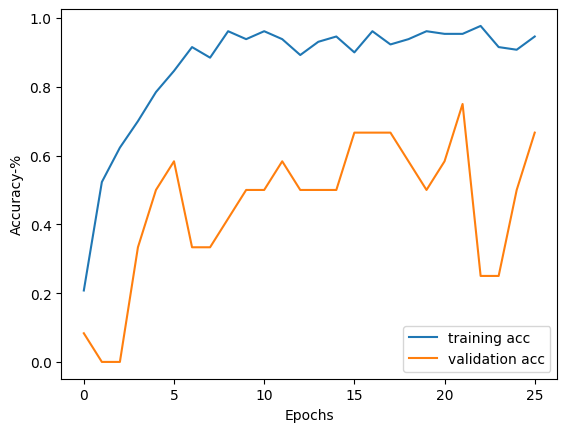

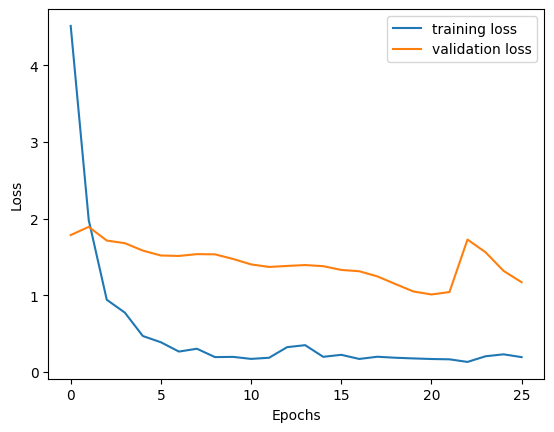

In [28]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

In [29]:
#METRICS
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Predict the classes and probabilities for the test dataset
test_pred_prob = model_inceptionv3.predict(test_ds)
test_pred = np.argmax(test_pred_prob, axis=1)
test_true = test_ds.labels

# Determine the number of classes in the test dataset
n_classes = len(np.unique(test_true))

# 2. Compute the metrics for the test dataset

# Test metrics
test_precision = precision_score(test_true, test_pred, average='weighted', zero_division=1)
test_recall = recall_score(test_true, test_pred, average='weighted')
test_f1 = f1_score(test_true, test_pred, average='weighted')
test_conf_matrix = confusion_matrix(test_true, test_pred, labels=list(range(n_classes)))
test_true_onehot = np.eye(n_classes)[test_true]
test_roc_auc = roc_auc_score(test_true_onehot, test_pred_prob, multi_class='ovr')

# Create a dataframe to display the results for the test set
test_metrics_df = pd.DataFrame({
    'Test': [test_precision, test_recall, test_f1, test_roc_auc]
}, index=['Precision', 'Recall', 'F1 Score', 'AUC'])

print("Test Metrics DataFrame:")
print(test_metrics_df)

print("\nTest Confusion Matrix:")
print(test_conf_matrix)


2/2 [==============================] - 3s 35ms/step
Test Metrics DataFrame:
               Test
Precision  0.402128
Recall     0.382979
F1 Score   0.271791
AUC        0.500300

Test Confusion Matrix:
[[18  1  3  0  0]
 [ 9  0  2  0  0]
 [ 5  0  0  0  0]
 [ 6  0  1  0  0]
 [ 2  0  0  0  0]]


In [30]:
# Assuming test_conf_matrix is already computed as shown in your code
n_classes = len(np.unique(test_true))  # Number of classes

# Initialize arrays to store TP, FP, FN, TN for each class
TP = np.zeros(n_classes)
FP = np.zeros(n_classes)
FN = np.zeros(n_classes)
TN = np.zeros(n_classes)

# Calculate TP, FP, FN, TN for each class
for i in range(n_classes):
    TP[i] = test_conf_matrix[i, i]
    FP[i] = test_conf_matrix[:, i].sum() - TP[i]
    FN[i] = test_conf_matrix[i, :].sum() - TP[i]
    TN[i] = test_conf_matrix.sum() - (FP[i] + FN[i] + TP[i])

print("Confusion Matrix Metrics by Class:")
TP_list = TP.tolist()
TN_list = TN.tolist()
FP_list = FP.tolist()
FN_list = FN.tolist()

metrics_by_class = list(zip(TP_list, TN_list, FP_list, FN_list))

# Print the transposed lists
for i, class_metrics in enumerate(metrics_by_class):
    print(f"Class {i}: {class_metrics}")

Confusion Matrix Metrics by Class:
Class 0: (18.0, 3.0, 22.0, 4.0)
Class 1: (0.0, 35.0, 1.0, 11.0)
Class 2: (0.0, 36.0, 6.0, 5.0)
Class 3: (0.0, 40.0, 0.0, 7.0)
Class 4: (0.0, 45.0, 0.0, 2.0)


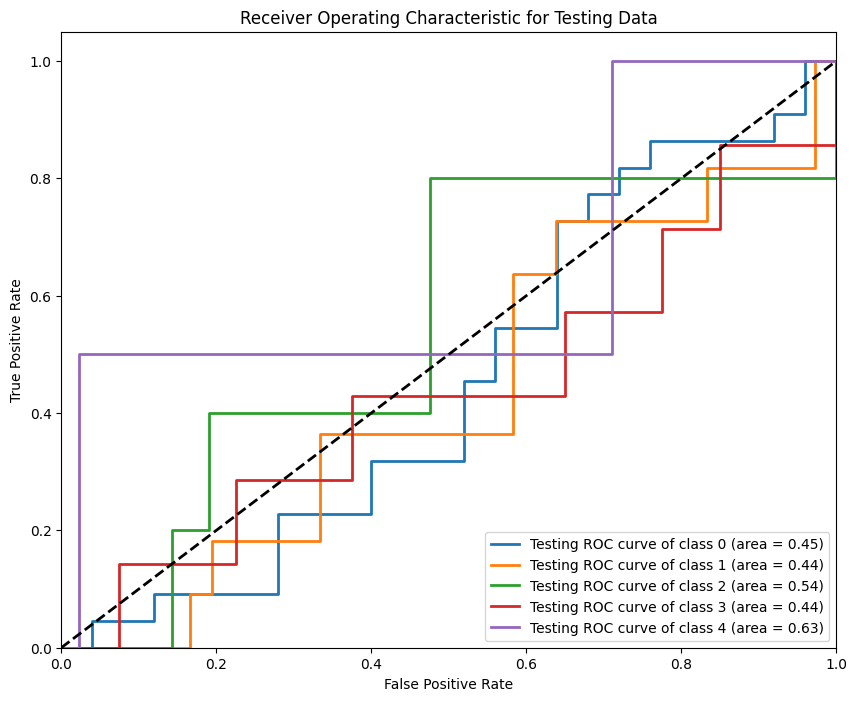

In [31]:
#Matrix Visualization
# Training AUC curve
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(test_true_onehot[:, i], test_pred_prob[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'Testing ROC curve of class {i} (area = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Testing Data')
plt.legend(loc="lower right")
plt.show()

In [32]:
#TEST CASES INSERTION

# Assuming that the TP_list, TN_list, FP_list, and FN_list have been calculated
TP_list = TP.tolist()
TN_list = TN.tolist()
FP_list = FP.tolist()
FN_list = FN.tolist()
metrics_flat = [item for sublist in zip(TP_list, TN_list, FP_list, FN_list) for item in sublist]

# Data to append
data_to_append = [
    #ACCCURACY AND LOSS
    train_result[0],  # Training loss [B]
    train_result[1],  # Training accuracy [C]
    val_result[0],    # Validation loss [D]
    val_result[1],     # Validation accuracy [E]
    test_result[0],    # Testing loss [F]
    test_result[1],     # Testing accuracy [G]
    test_precision,
    test_recall,
    test_f1,
    test_roc_auc
]

#Insertion
# Find the first empty row in column B
col_values = sheet.col_values(2)  # Column number for 'B' is 2
first_empty_row = len(col_values) + 1

# Calculate the range to update
start_cell = rowcol_to_a1(first_empty_row, 2)  # Start at column B
end_cell = rowcol_to_a1(first_empty_row, 1 + len(data_to_append))  # Adjust the end column based on data length
cell_range = f"{start_cell}:{end_cell}"

# Update the entire row at once
sheet.update(cell_range, [data_to_append])

#FOR CONFUSION MATRIX INSERTION
# Loop through the metrics_flat and update each cell
for index, value in enumerate(metrics_flat):
    # Calculate row and column offset
    row_offset = (index // 4) + first_empty_row
    col_offset = (index % 4) + 12

    # Convert to A1 notation and update the cell
    cell_range = rowcol_to_a1(first_empty_row, 12) + ':' + rowcol_to_a1(first_empty_row, 12 + len(metrics_flat) - 1)
    sheet.update(cell_range, [metrics_flat])

In [33]:
# Add a ReduceLROnPlateau callback to reduce the learning rate when the validation loss plateaus
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001, #to change reduce_lr
    verbose=1
)
callbacks_list = [checkpoint, early, time_callback, reduce_lr]

history = model_inceptionv3.fit(
        aug_train_ds,
        validation_data=val_ds,
        epochs=30,
        shuffle=True,
        verbose=True,
        callbacks=callbacks_list,
        class_weight=class_weight_dict  # Pass class weights here
        )


Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 1.9255 - accuracy: 0.5414
Epoch 1: val_loss did not improve from 1.01089
Epoch 1: 17.50 seconds
18/18 [==============================] - 17s 969ms/step - loss: 1.9255 - accuracy: 0.5414 - val_loss: 1.1400 - val_accuracy: 0.5833 - lr: 0.0010
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 1.0764 - accuracy: 0.5785
Epoch 2: val_loss did not improve from 1.01089
Epoch 2: 11.16 seconds
18/18 [==============================] - 11s 597ms/step - loss: 1.0764 - accuracy: 0.5785 - val_loss: 1.2240 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/30
18/18 [==============================] - ETA: 0s - loss: 0.7095 - accuracy: 0.6861
Epoch 3: val_loss did not improve from 1.01089
Epoch 3: 11.28 seconds
18/18 [==============================] - 11s 605ms/step - loss: 0.7095 - accuracy: 0.6861 - val_loss: 1.0796 - val_accuracy: 0.5833 - lr: 0.0010
Epoch 4/30
18/18 [==============================] - ETA: 0s - loss: 0.591

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 4: 15.59 seconds
18/18 [==============================] - 16s 858ms/step - loss: 0.5910 - accuracy: 0.7460 - val_loss: 0.9678 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 5/30
18/18 [==============================] - ETA: 0s - loss: 0.5059 - accuracy: 0.8042
Epoch 5: val_loss improved from 0.96783 to 0.95277, saving model to /content/drive/My Drive/THESIS 2/model/inceptionv3_tuned_hybrid.h5
Epoch 5: 12.16 seconds
18/18 [==============================] - 12s 655ms/step - loss: 0.5059 - accuracy: 0.8042 - val_loss: 0.9528 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 6/30
18/18 [==============================] - ETA: 0s - loss: 0.4121 - accuracy: 0.8395
Epoch 6: val_loss did not improve from 0.95277
Epoch 6: 10.73 seconds
18/18 [==============================] - 11s 572ms/step - loss: 0.4121 - accuracy: 0.8395 - val_loss: 1.0730 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 7/30
18/18 [==============================] - ETA: 0s - loss: 0.3380 - accuracy: 0.8571
Epoch 7: val_loss did not improv

## Evaluation of *Tuned Model* with **Augmentation**

In [34]:
train_result = model_inceptionv3.evaluate(train_ds)
val_result = model_inceptionv3.evaluate(val_ds)
test_result = model_inceptionv3.evaluate(test_ds)

augmented_df = pd.DataFrame(zip(train_result,val_result,test_result),columns=['Train','Val','Test'],index=['Loss','Acc'])
augmented_df

2/2 [==============================] - 1s 262ms/step - loss: 0.5199 - accuracy: 0.8298


,Train,Val,Test
Loss,0.284454,0.576874,0.519917
Acc,0.938462,0.666667,0.829787


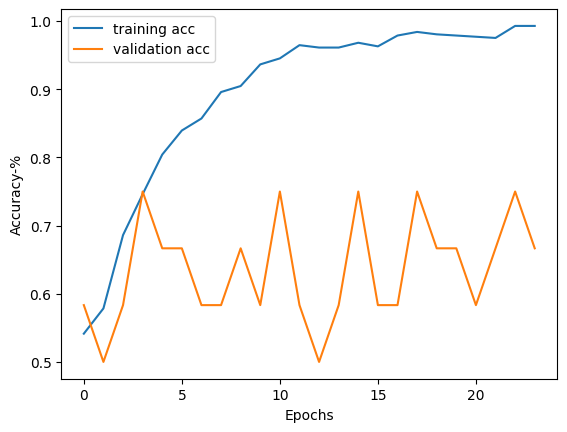

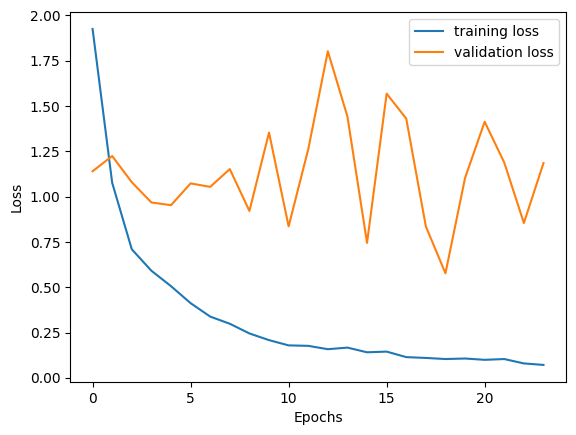

In [35]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy-%')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_learning_curve(history)

In [36]:
#METRICS
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Predict the classes and probabilities for the test dataset
test_pred_prob = model_inceptionv3.predict(test_ds)
test_pred = np.argmax(test_pred_prob, axis=1)
test_true = test_ds.labels

# Determine the number of classes in the test dataset
n_classes = len(np.unique(test_true))

# 2. Compute the metrics for the test dataset

# Test metrics
test_precision = precision_score(test_true, test_pred, average='weighted', zero_division=1)
test_recall = recall_score(test_true, test_pred, average='weighted')
test_f1 = f1_score(test_true, test_pred, average='weighted')
test_conf_matrix = confusion_matrix(test_true, test_pred, labels=list(range(n_classes)))
test_true_onehot = np.eye(n_classes)[test_true]
test_roc_auc = roc_auc_score(test_true_onehot, test_pred_prob, multi_class='ovr')

# Create a dataframe to display the results for the test set
test_metrics_df = pd.DataFrame({
    'Test': [test_precision, test_recall, test_f1, test_roc_auc]
}, index=['Precision', 'Recall', 'F1 Score', 'AUC'])

print("Test Metrics DataFrame:")
print(test_metrics_df)

print("\nTest Confusion Matrix:")
print(test_conf_matrix)


2/2 [==============================] - 1s 495ms/step
Test Metrics DataFrame:
               Test
Precision  0.402340
Recall     0.361702
F1 Score   0.366504
AUC        0.565059

Test Confusion Matrix:
[[12  2  5  3  0]
 [ 6  3  2  0  0]
 [ 1  0  0  3  1]
 [ 4  0  0  2  1]
 [ 2  0  0  0  0]]


In [37]:
# Assuming test_conf_matrix is already computed as shown in your code
n_classes = len(np.unique(test_true))  # Number of classes

# Initialize arrays to store TP, FP, FN, TN for each class
TP = np.zeros(n_classes)
FP = np.zeros(n_classes)
FN = np.zeros(n_classes)
TN = np.zeros(n_classes)

# Calculate TP, FP, FN, TN for each class
for i in range(n_classes):
    TP[i] = test_conf_matrix[i, i]
    FP[i] = test_conf_matrix[:, i].sum() - TP[i]
    FN[i] = test_conf_matrix[i, :].sum() - TP[i]
    TN[i] = test_conf_matrix.sum() - (FP[i] + FN[i] + TP[i])

print("Confusion Matrix Metrics by Class:")
TP_list = TP.tolist()
TN_list = TN.tolist()
FP_list = FP.tolist()
FN_list = FN.tolist()

metrics_by_class = list(zip(TP_list, TN_list, FP_list, FN_list))

# Print the transposed lists
for i, class_metrics in enumerate(metrics_by_class):
    print(f"Class {i}: {class_metrics}")

Confusion Matrix Metrics by Class:
Class 0: (12.0, 12.0, 13.0, 10.0)
Class 1: (3.0, 34.0, 2.0, 8.0)
Class 2: (0.0, 35.0, 7.0, 5.0)
Class 3: (2.0, 34.0, 6.0, 5.0)
Class 4: (0.0, 43.0, 2.0, 2.0)


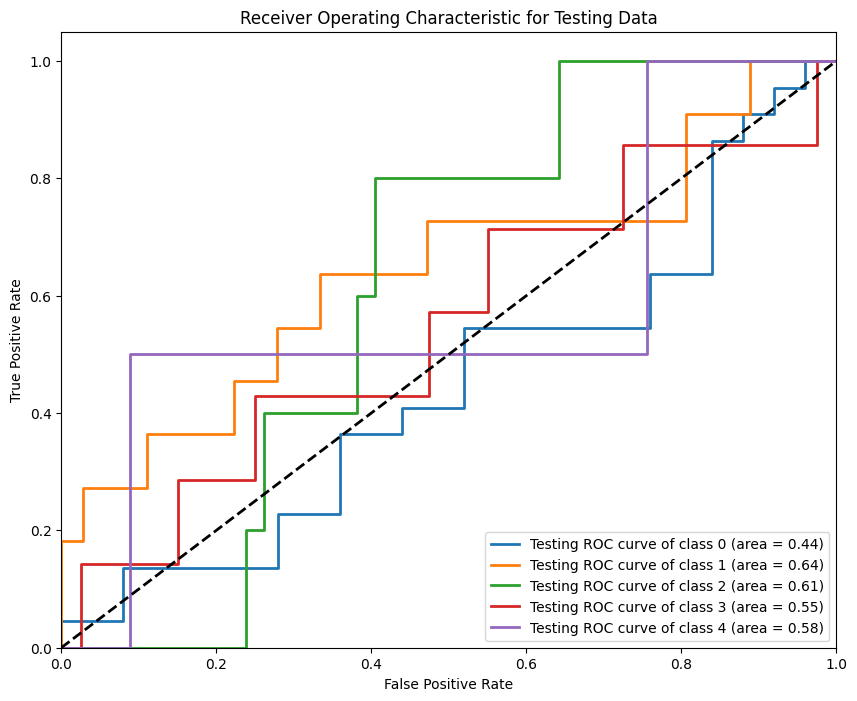

In [38]:
#Matrix Visualization
# Training AUC curve
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(test_true_onehot[:, i], test_pred_prob[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'Testing ROC curve of class {i} (area = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Testing Data')
plt.legend(loc="lower right")
plt.show()

In [39]:
#TEST CASES INSERTION

# Assuming that the TP_list, TN_list, FP_list, and FN_list have been calculated
TP_list = TP.tolist()
TN_list = TN.tolist()
FP_list = FP.tolist()
FN_list = FN.tolist()
metrics_flat = [item for sublist in zip(TP_list, TN_list, FP_list, FN_list) for item in sublist]

# Data to append
data_to_append = [
    #ACCCURACY AND LOSS
    train_result[0],  # Training loss [B]
    train_result[1],  # Training accuracy [C]
    val_result[0],    # Validation loss [D]
    val_result[1],     # Validation accuracy [E]
    test_result[0],    # Testing loss [F]
    test_result[1],     # Testing accuracy [G]
    test_precision,
    test_recall,
    test_f1,
    test_roc_auc
]

#Insertion
# Find the first empty row in column B
col_values = sheet.col_values(2)  # Column number for 'B' is 2
first_empty_row = len(col_values) + 1

# Calculate the range to update
start_cell = rowcol_to_a1(first_empty_row, 2)  # Start at column B
end_cell = rowcol_to_a1(first_empty_row, 1 + len(data_to_append))  # Adjust the end column based on data length
cell_range = f"{start_cell}:{end_cell}"

# Update the entire row at once
sheet.update(cell_range, [data_to_append])

#FOR CONFUSION MATRIX INSERTION
# Loop through the metrics_flat and update each cell
for index, value in enumerate(metrics_flat):
    # Calculate row and column offset
    row_offset = (index // 4) + first_empty_row
    col_offset = (index % 4) + 12

    # Convert to A1 notation and update the cell
    cell_range = rowcol_to_a1(first_empty_row, 12) + ':' + rowcol_to_a1(first_empty_row, 12 + len(metrics_flat) - 1)
    sheet.update(cell_range, [metrics_flat])

## Metrics of Final Model

In [40]:
# # plot learning curve
# def plot_learning_curve(history):
#     acc = history.history['acc']
#     val_acc = history.history['val_acc']
#     loss = history.history['loss']
#     val_loss = history.history['val_loss']
#     epochs = range(len(acc))

#     plt.plot(epochs, acc, label='training acc')
#     plt.plot(epochs, val_acc, label='validation acc')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy-%')
#     plt.legend()
#     plt.figure()

#     plt.plot(epochs, loss, label='training loss')
#     plt.plot(epochs, val_loss, label='validation loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()

# plot_learning_curve(history)

In [41]:
# from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
# import matplotlib.pyplot as plt

# # 1. Predict the classes and probabilities for the training and validation datasets
# train_pred_prob = model_inceptionv3.predict(train_ds)
# train_pred = np.argmax(train_pred_prob, axis=1)
# train_true = train_ds.labels

# val_pred_prob = model_inceptionv3.predict(val_ds)
# val_pred = np.argmax(val_pred_prob, axis=1)
# val_true = val_ds.labels

# n_classes = len(np.unique(train_true))

# # 2. Compute the metrics for both training and validation datasets

# # Training metrics
# train_precision = precision_score(train_true, train_pred, average='weighted', zero_division=1)
# # train_precision = precision_score(train_true, train_pred, average='weighted')
# train_recall = recall_score(train_true, train_pred, average='weighted')
# train_f1 = f1_score(train_true, train_pred, average='weighted')
# train_conf_matrix = confusion_matrix(train_true, train_pred)
# train_true_onehot = np.eye(n_classes)[train_true]
# train_roc_auc = roc_auc_score(train_true_onehot, train_pred_prob, multi_class='ovr')

# # Validation metrics
# val_precision = precision_score(val_true, val_pred, average='weighted', zero_division=1)
# # val_precision = precision_score(val_true, val_pred, average='weighted')
# val_recall = recall_score(val_true, val_pred, average='weighted')
# val_f1 = f1_score(val_true, val_pred, average='weighted')
# val_conf_matrix = confusion_matrix(val_true, val_pred)
# val_true_onehot = np.eye(n_classes)[val_true]
# val_roc_auc = roc_auc_score(val_true_onehot, val_pred_prob, multi_class='ovr')

# # Create a dataframe to display the results
# metrics_df = pd.DataFrame({
#     'Train': [train_precision, train_recall, train_f1, train_roc_auc],
#     'Val': [val_precision, val_recall, val_f1, val_roc_auc]
# }, index=['Precision', 'Recall', 'F1 Score', 'AUC'])

# print("Metrics DataFrame:")
# print(metrics_df)

# print("\nTraining Confusion Matrix:")
# print(train_conf_matrix)

# print("\nValidation Confusion Matrix:")
# print(val_conf_matrix)


In [42]:
# # Training AUC curve
# plt.figure(figsize=(10, 8))
# for i in range(n_classes):
#     fpr, tpr, _ = roc_curve(train_true_onehot[:, i], train_pred_prob[:, i])
#     plt.plot(fpr, tpr, lw=2, label=f'Training ROC curve of class {i} (area = {auc(fpr, tpr):.2f})')
# plt.plot([0, 1], [0, 1], 'k--', lw=2)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic for Training Data')
# plt.legend(loc="lower right")
# plt.show()

# # Validation AUC curve
# plt.figure(figsize=(10, 8))
# for i in range(n_classes):
#     fpr, tpr, _ = roc_curve(val_true_onehot[:, i], val_pred_prob[:, i])
#     plt.plot(fpr, tpr, lw=2, linestyle='--', label=f'Validation ROC curve of class {i} (area = {auc(fpr, tpr):.2f})')
# plt.plot([0, 1], [0, 1], 'k--', lw=2)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic for Validation Data')
# plt.legend(loc="lower right")
# plt.show()
